# Generic Churn Prediction Engine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv(r'C:\Users\surya\Downloads\train.csv\train.csv')
orig_df=pd.read_csv(r'C:\Users\surya\Downloads\Churn_Modelling.csv').rename(columns={'RowNumber':'id'})
df_test=pd.read_csv(r'C:\Users\surya\Downloads\test.csv\test.csv')

In [3]:
df=pd.concat([df,orig_df],ignore_index=True)
df.drop(['id'],axis=1,inplace=True)

In [4]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175036 entries, 0 to 175035
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       175036 non-null  int64  
 1   Surname          175036 non-null  object 
 2   CreditScore      175036 non-null  int64  
 3   Geography        175035 non-null  object 
 4   Gender           175036 non-null  object 
 5   Age              175035 non-null  float64
 6   Tenure           175036 non-null  int64  
 7   Balance          175036 non-null  float64
 8   NumOfProducts    175036 non-null  int64  
 9   HasCrCard        175035 non-null  float64
 10  IsActiveMember   175035 non-null  float64
 11  EstimatedSalary  175036 non-null  float64
 12  Exited           175036 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.4+ MB


In [6]:
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.dropna(inplace=True)

# DATA PREPROCESSING

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def tfidf_pca_transformer(data, column, max_features, n_components):
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(data[column])

    svd = TruncatedSVD(n_components=n_components)
    svd_result = svd.fit_transform(tfidf_matrix)

    tfidf_df = pd.DataFrame(svd_result, columns=[f"{column}_tfidf_{i}" for i in range(n_components)])
    result_df = pd.concat([data, tfidf_df], axis='columns')

    return result_df

In [9]:
object_dat=['Geography', 'Gender']

In [ ]:
# from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
lb.fit(df['Surname'])
def preprocess(data):
    data = tfidf_pca_transformer(data, column="Surname", max_features=1000, n_components=5)
    
    data.drop(['CustomerId'],axis=1,inplace=True)
    data.dropna(inplace=True)
    
    data['Surname']=lb.transform(data['Surname'])
    
    for i in object_dat:
        data=pd.concat([data,pd.get_dummies(data[i])*1],axis=1)
        data.drop([i],axis=1,inplace=True)
    
    data['Age']=data['Age'].round()
    data['Mem__no__Products'] = data['NumOfProducts'] * data['IsActiveMember']
    data["Cred_Bal_Sal"] = (data["CreditScore"] * data["Balance"] ) / data["EstimatedSalary"]
    data["Bal_sal"] = data["Balance"] / data["EstimatedSalary"]
    data["Tenure_Age"] = data["Tenure"] / data["Age"]
    data["Age_Tenure_product"] = data["Age"] * data["Tenure"]
    data["IsSenior"] = data['Age'].apply(lambda x: 1 if x >= 60 else 0)
    
    scaling_cols = ['Age','Tenure','CreditScore','Balance','EstimatedSalary','Cred_Bal_Sal','Bal_sal','Age_Tenure_product']
    for i in scaling_cols:
        min_val=data[i].min()
        max_val=data[i].max()
        data[f'{i}_sc']=(data[i]-min_val)/(max_val-min_val)
    
    data['HasCrCard'] = data['HasCrCard'].astype('int64')
    data['IsActiveMember'] = data['IsActiveMember'].astype('int64')
    data['Age'] = data['Age'].astype('int64')
    return data

In [11]:
df=preprocess(df)
df['Exited'] = df['Exited'].astype('int64')

# EDA

In [12]:
df.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,Age_Tenure_product,IsSenior,Age_sc,Tenure_sc,CreditScore_sc,Balance_sc,EstimatedSalary_sc,Cred_Bal_Sal_sc,Bal_sal_sc,Age_Tenure_product_sc
0,2023,668.0,33,3.0,0.00,2.0,1,0,181449.97,0,...,99.0,0,0.202703,0.3,0.636,0.000000,0.907279,0.000000,0.000000,0.112500
1,2024,627.0,33,1.0,0.00,2.0,1,1,49503.50,0,...,33.0,0,0.202703,0.1,0.554,0.000000,0.247483,0.000000,0.000000,0.037500
2,1236,678.0,40,10.0,0.00,2.0,1,0,184866.69,0,...,400.0,0,0.297297,1.0,0.656,0.000000,0.924364,0.000000,0.000000,0.454545
3,1362,581.0,34,2.0,148882.54,1.0,1,1,84560.88,0,...,68.0,0,0.216216,0.2,0.462,0.593398,0.422787,0.000118,0.000137,0.077273
4,491,716.0,33,5.0,0.00,2.0,1,1,15068.83,0,...,165.0,0,0.202703,0.5,0.732,0.000000,0.075293,0.000000,0.000000,0.187500


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175028 entries, 0 to 175031
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Surname                175028 non-null  int32  
 1   CreditScore            175028 non-null  float64
 2   Age                    175028 non-null  int64  
 3   Tenure                 175028 non-null  float64
 4   Balance                175028 non-null  float64
 5   NumOfProducts          175028 non-null  float64
 6   HasCrCard              175028 non-null  int64  
 7   IsActiveMember         175028 non-null  int64  
 8   EstimatedSalary        175028 non-null  float64
 9   Exited                 175028 non-null  int64  
 10  Surname_tfidf_0        175028 non-null  float64
 11  Surname_tfidf_1        175028 non-null  float64
 12  Surname_tfidf_2        175028 non-null  float64
 13  Surname_tfidf_3        175028 non-null  float64
 14  Surname_tfidf_4        175028 non-nu

In [14]:
df.to_csv('Dataset.csv',index=False)

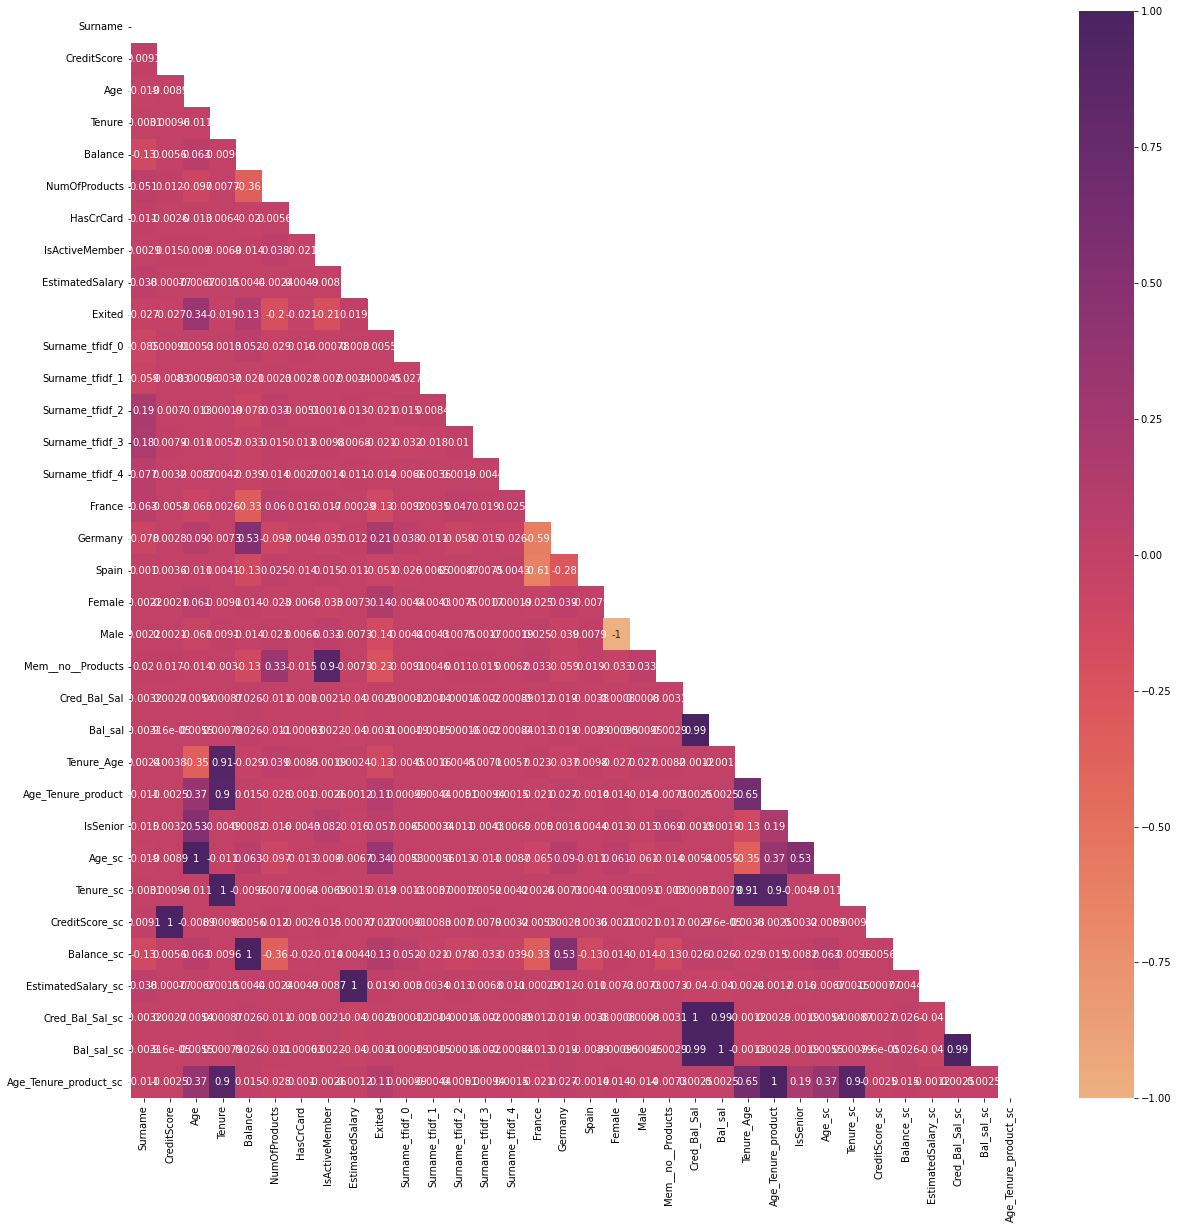

In [15]:
#Correlation Matrix

plt.figure(figsize=(20,20))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='flare',mask=np.triu(corr))
plt.show()

Targeting High-Credit, Established Customers:The heatmap suggests a positive correlation between credit score, age, and tenure, which might be inversely related to churn rate. You could focus marketing and retention efforts on attracting new customers with similar profiles or offering incentives to retain existing ones in this segment.

Investigating Younger Customer Churn: The potential negative correlation between age and the number of products suggests younger customers might churn more. Explore reasons behind this - are they less aware of available products, or are competitor offerings more appealing? Develop targeted product recommendations or educational resources to address their needs and increase product adoption.

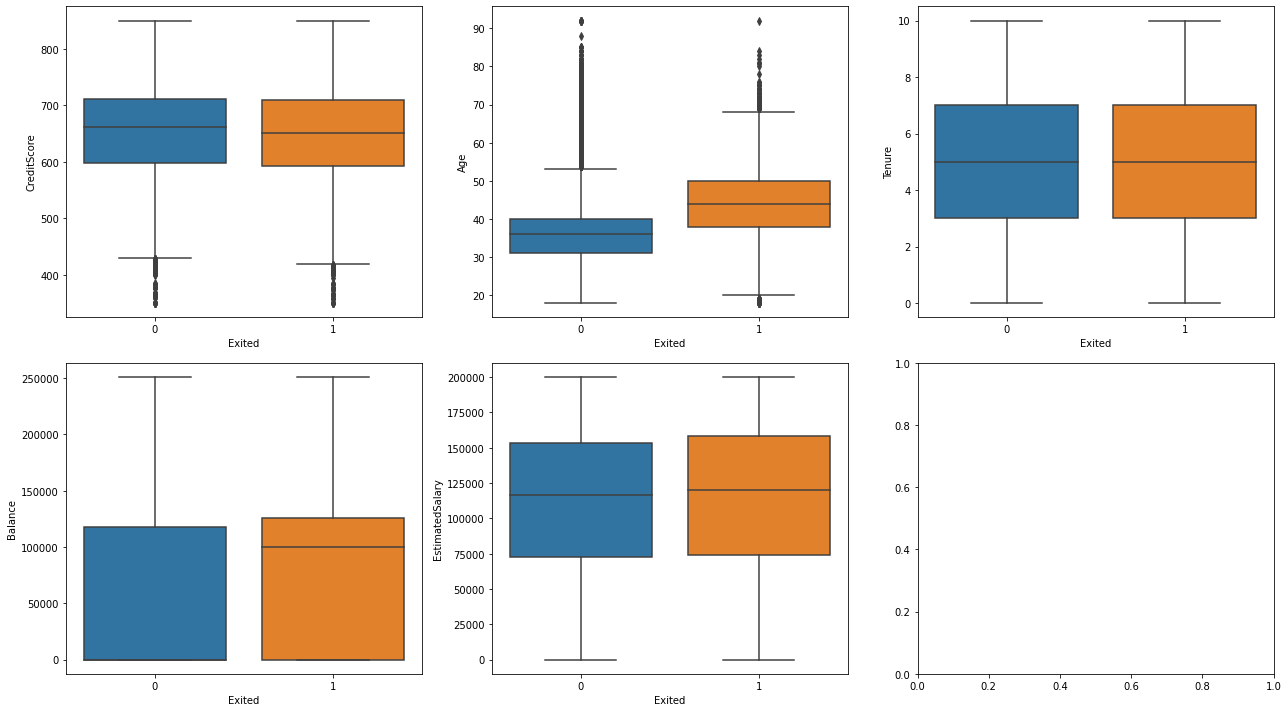

In [17]:
# Churn analysis by numerical variables
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
for i, col in enumerate(num_cols):
    sns.boxplot(x='Exited', y=col, data=df, ax=axes[i//3, i%3])
plt.tight_layout()
plt.show()


The box plot for estimated salary_sc (presumably scaled estimated salary) is less clear. There's some overlap between the distributions for churned and non-churned customers. While the median estimated salary_sc might be slightly higher for non-churned customers, the relationship is weaker compared to balance_sc and credit score_sc.where balance_sc , credit score_sc are directly proportional.

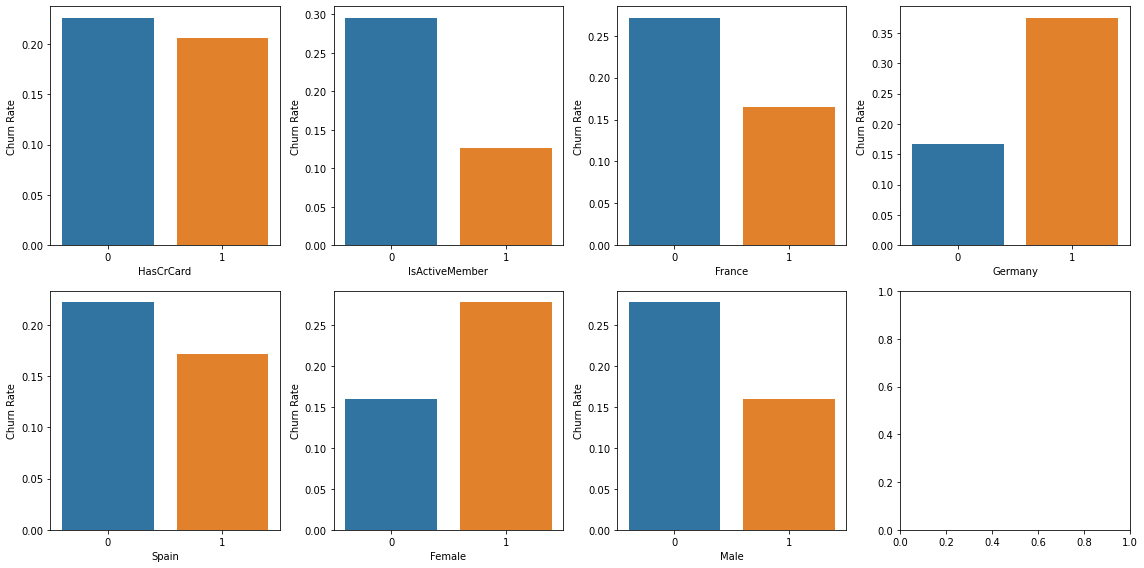

In [18]:
# Churn rate by categorical variables
cat_cols = ['HasCrCard', 'IsActiveMember', 'France', 'Germany', 'Spain', 'Female', 'Male']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='Exited', data=df, ax=axes[i//4, i%4], ci=None)
    axes[i//4, i%4].set_ylabel('Churn Rate')
plt.tight_layout()
plt.show()


churn rate is lower for customers who had credit card

Female had more churn rates than male

Germany had more churn rate than france, spain

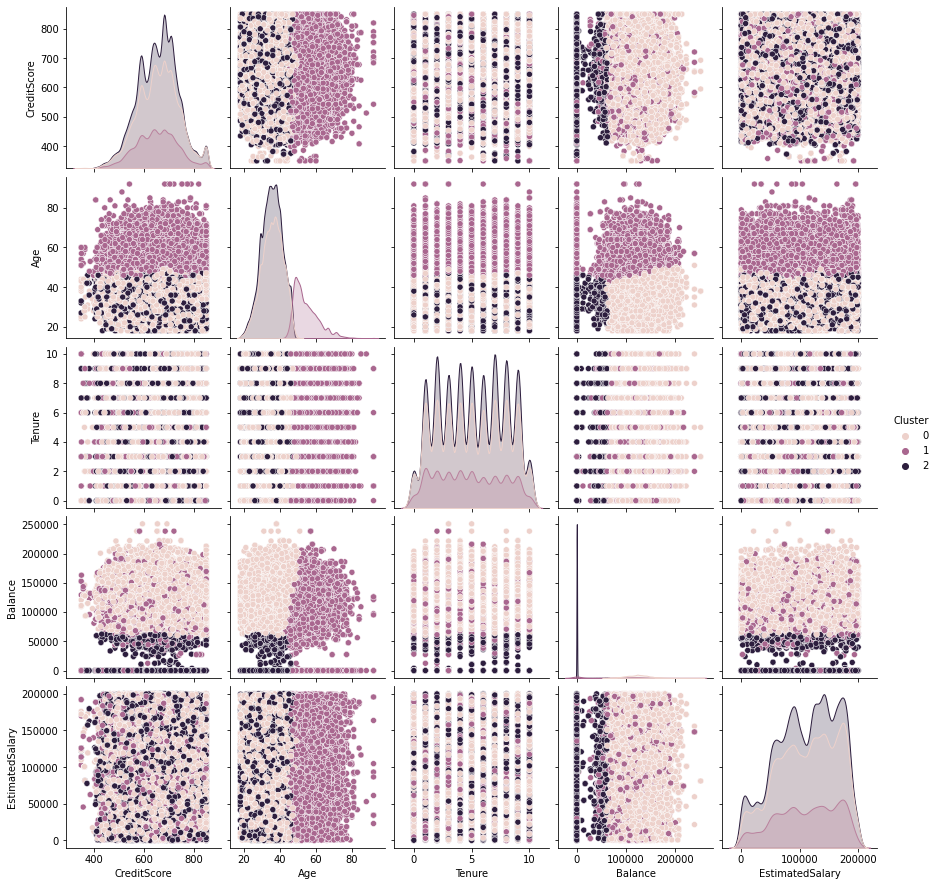

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
cluster_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_cols])

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
sns.pairplot(df, hue='Cluster', vars=cluster_cols)
plt.show()


Insight:

CreditScore: Shows a normal distribution with clusters indicating different groupings of customers based on other factors.
Age: Clustering visible, possibly separating younger and older customers.
Tenure: Tenure does not show a clear pattern with clusters.
Balance: Higher balances are clustered separately, indicating wealthier customers might be distinct.
EstimatedSalary: Shows different patterns in each cluster, indicating a correlation with customer segmentation.
Unique Insight: Clusters reveal distinct segments of customers, which can be used to tailor marketing strategies and services.

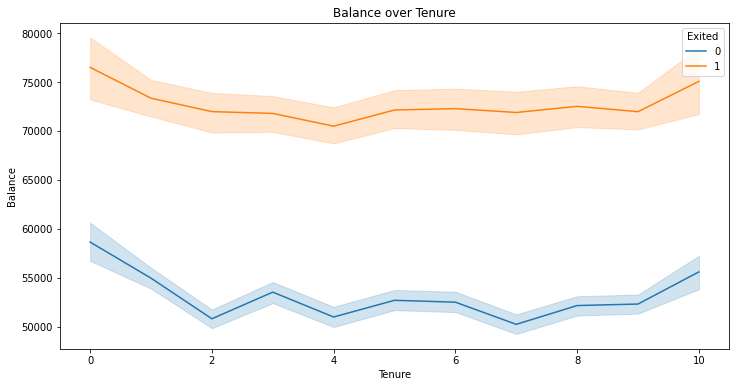

In [23]:
# Assuming Tenure is your time-related variable
plt.figure(figsize=(12, 6))
sns.lineplot(x='Tenure', y='Balance', hue='Exited', data=df)
plt.title('Balance over Tenure')
plt.xlabel('Tenure')
plt.ylabel('Balance')
plt.show()


This suggests that customers with lower balances are more likely to churn.

This suggests that customers tend to have higher balances the longer they have been with the bank.

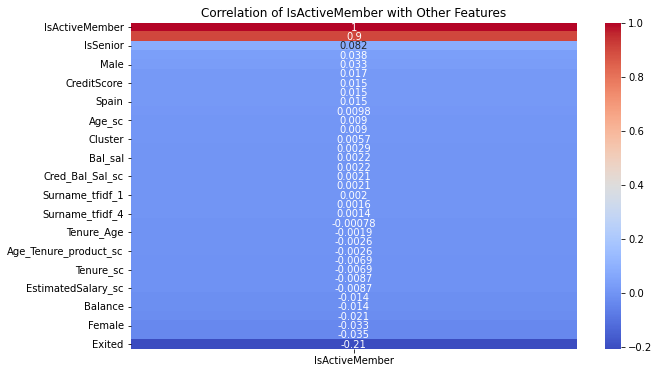

In [24]:
# Correlation of IsActiveMember with other features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr()[['IsActiveMember']].sort_values(by='IsActiveMember', ascending=False), cmap='coolwarm', annot=True)
plt.title('Correlation of IsActiveMember with Other Features')
plt.show()

Survival analysis can help understand the duration until customers churn based on different variables. 
Here clearly shown that senior , male , credit score are main reasons for active customers without churning.

<Figure size 576x432 with 0 Axes>

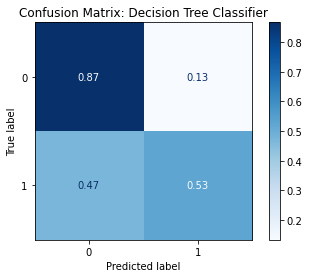

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     27606
           1       0.52      0.53      0.52      7400

    accuracy                           0.80     35006
   macro avg       0.69      0.70      0.70     35006
weighted avg       0.80      0.80      0.80     35006



In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix

# Prepare data for decision tree
X_churn = df.drop(['Exited'], axis=1)
y_churn = df['Exited']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_churn, y_churn, test_size=0.2, random_state=42)

# Fit decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(dt_classifier, X_test, y_test, cmap='Blues', normalize='true')
plt.title('Confusion Matrix: Decision Tree Classifier')
plt.show()

# Print classification report
y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred))


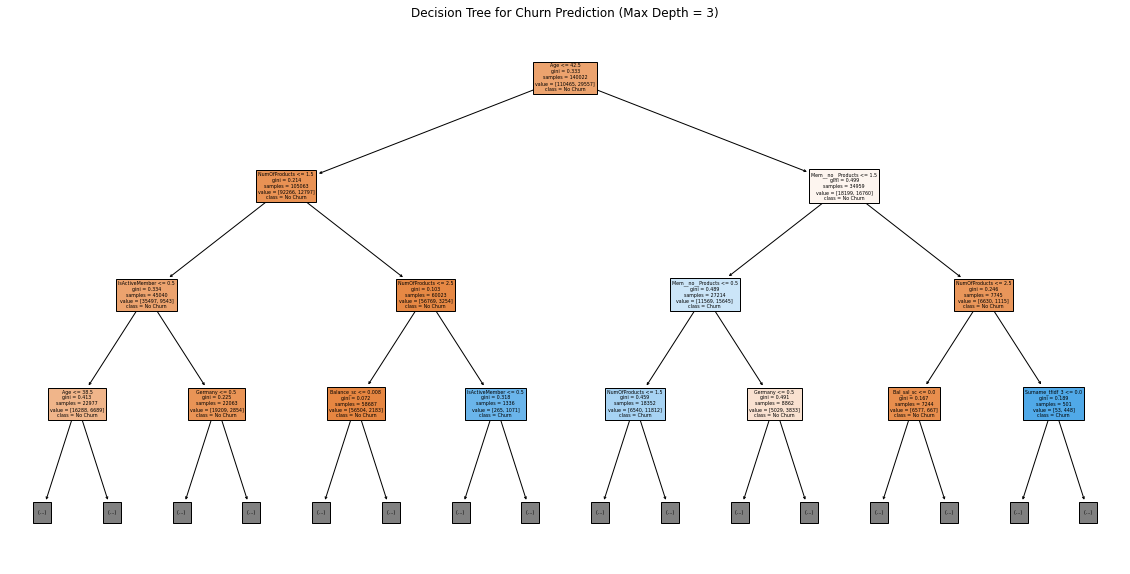

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_churn.columns, class_names=['No Churn', 'Churn'], max_depth=3)
plt.title('Decision Tree for Churn Prediction (Max Depth = 3)')
plt.show()



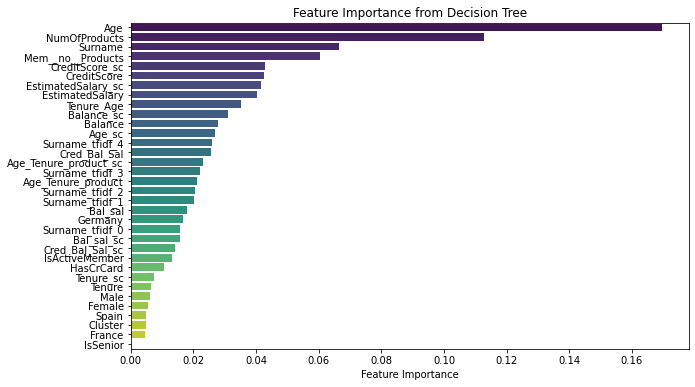

In [28]:
# Plotting feature importance from the decision tree
feature_importances = pd.Series(dt_classifier.feature_importances_, index=X_churn.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, orient='h', palette='viridis')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree')
plt.show()


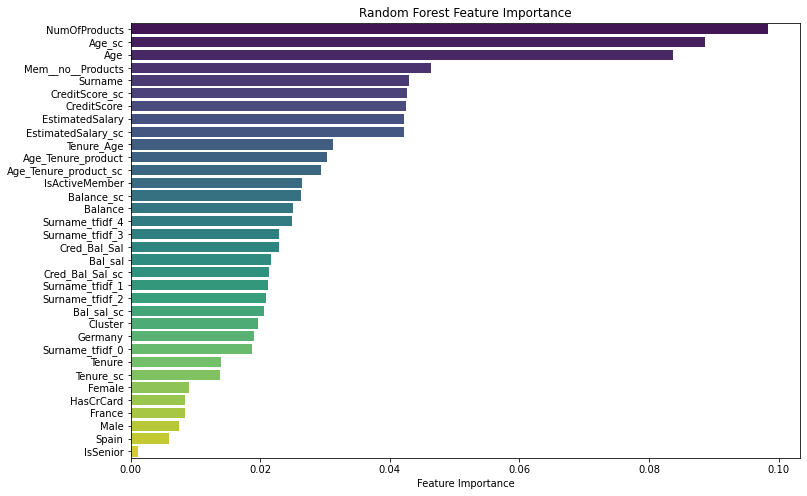

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'Exited' is your target variable
X = df.drop(['Exited'], axis=1)
y = df['Exited']

# Fit a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index, orient='h', palette='viridis')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

1.Customers' age is a key factor in churn prediction. This could be because younger customers are less likely to be settled into a routine and more likely to be attracted to competitor offerings.

2.The number of products a customer has is also an important factor. This suggests that customers who have more products are more invested in the company and less likely to churn.

3.customer's surname is also a relatively important factor. This could be due to correlations between surnames and demographics (e.g., country of origin) that are in turn correlated with churn. However, it's important to be cautious about interpreting this finding, as it could also be due to spurious correlations or biases in the data.

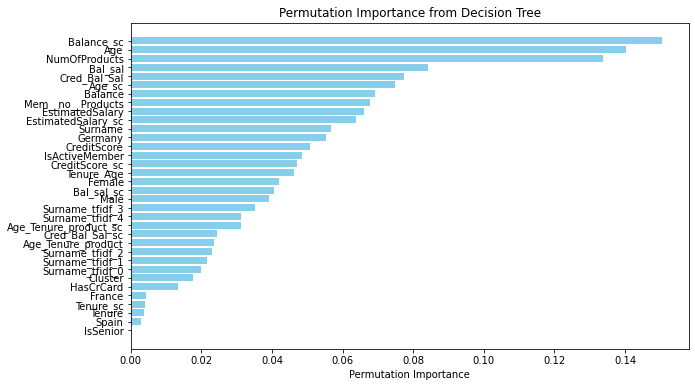

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Example for permutation importance
perm_importance = permutation_importance(dt_classifier, X_churn, y_churn)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_churn.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance from Decision Tree')
plt.show()


Agreement: Both analyses highlight the importance of age and potentially financial stability (balance or credit score) in predicting churn.
Discrepancies:
Previous image: Emphasized "Surname" potentially due to its position in the tree. The current image suggests TF-IDF features derived from surnames might be more relevant.
Previous image: May not have shown the importance of "Tenure Age" (combined feature) as clearly as the current image.

# MODEL BUILDING

In [30]:
x=df.drop(['Exited'],axis=1)
y=df[['Exited']]

In [31]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42,shuffle=True)

In [32]:
DTC=DecisionTreeClassifier(random_state=0)
LR=LogisticRegression()
RFC=RandomForestClassifier(n_estimators=23,random_state=0)
KNN=KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
NB=GaussianNB()

In [33]:
DTC.fit(x_train,y_train)
LR.fit(x_train,y_train)
RFC.fit(x_train,y_train)
KNN.fit(x_train,y_train)
NB.fit(x_train,y_train)

GaussianNB()

In [34]:
pred_DTC=DTC.predict_proba(x_test)
pred_DTC=[i[1] for i in pred_DTC]
pred_LR=LR.predict_proba(x_test)
pred_LR=[i[1] for i in pred_LR]
pred_RFC=RFC.predict_proba(x_test)
pred_RFC=[i[1] for i in pred_RFC]
pred_KNN=KNN.predict_proba(x_test)
pred_KNN=[i[1] for i in pred_KNN]
pred_NB=NB.predict_proba(x_test)
pred_NB=[i[1] for i in pred_NB]

In [35]:
print("Decision Tree Classification ROC score =",roc_auc_score(y_test,pred_DTC))
print("****************************************************************")
print("Logistic Regression ROC score =",roc_auc_score(y_test,pred_LR))
print("****************************************************************")
print("Random Forest Classification ROC score =",roc_auc_score(y_test,pred_RFC))
print("****************************************************************")
print("K Nearest Neighbors ROC score =",roc_auc_score(y_test,pred_KNN))
print("****************************************************************")
print("Naive Bayes ROC score =",roc_auc_score(y_test,pred_NB))

Decision Tree Classification ROC score = 0.7028930305443685
****************************************************************
Logistic Regression ROC score = 0.6134182969284523
****************************************************************
Random Forest Classification ROC score = 0.8636239291479358
****************************************************************
K Nearest Neighbors ROC score = 0.5574942612143012
****************************************************************
Naive Bayes ROC score = 0.7715615268912988


In [36]:
from sklearn.ensemble import GradientBoostingClassifier
GBC=GradientBoostingClassifier()
GBC.fit(x_train,y_train)

GradientBoostingClassifier()

In [40]:
pred_GBC=GBC.predict_proba(x_test)
pred_GBC=[i[1] for i in pred_GBC]
print("Gradient Boosting ROC score =",roc_auc_score(y_test,pred_GBC))

Gradient Boosting ROC score = 0.8891914571514485


In [41]:
from xgboost import XGBClassifier
# XGB_params = {'booster': 'gbtree', 
#         'lambda': 8.803747805736341e-08, 
#         'alpha': 0.00010339545129413926,
#         'subsample': 0.6472067107394853,
#         'colsample_bytree': 0.9225973102702412,
#         'max_depth': 5,
#         'min_child_weight': 5,
#         'eta': 0.12477845463556776,
#         'gamma': 0.0021228439224434607,
#         'grow_policy': 'lossguide'}
XGB_params={'n_estimators': 1580,
                      'learning_rate': 0.01549093838586683,
                      'alpha': 0.926917946207397,
                      'subsample': 0.8749127473190033,
                      'colsample_bytree': 0.5264186380747528,
                      'max_depth': 6,
                      'min_child_weight': 1,
                      'gamma': 0.003713337191882183}

XGB=XGBClassifier(**XGB_params)
XGB.fit(x_train,y_train)

[23:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0.926917946207397, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5264186380747528, enable_categorical=False,
              gamma=0.003713337191882183, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01549093838586683,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1580, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.92691797, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8749127473190033, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [42]:
pred_XGB=XGB.predict_proba(x_test)
pred_XGB=[i[1] for i in pred_XGB]
print("XGB ROC score =",roc_auc_score(y_test,pred_XGB))

XGB ROC score = 0.8951342630512158


In [44]:
from sklearn.ensemble import AdaBoostClassifier
ABC=AdaBoostClassifier()
ABC.fit(x_train,y_train)

AdaBoostClassifier()

In [45]:
pred_ABC=ABC.predict_proba(x_test)
pred_ABC=[i[1] for i in pred_ABC]
print("AdaBoost ROC score =",roc_auc_score(y_test,pred_ABC))

AdaBoost ROC score = 0.8798047963603927


In [46]:
from catboost import CatBoostClassifier
CBC_params = {'iterations': 2348, 
                     'learning_rate': 0.027888186114456686,
                     'colsample_bylevel': 0.6678237610072195,
                     'random_strength': 0.09963299754527431,
                     'depth': 5,
                     'l2_leaf_reg': 7, 
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli', 
                     'subsample': 0.7831829918510387}
CBC=CatBoostClassifier(**CBC_params,verbose=0)
CBC.fit(x_train,y_train)

In [47]:
pred_CBC=CBC.predict_proba(x_test)
pred_CBC=[i[1] for i in pred_CBC]
print("CatBoost ROC score =",roc_auc_score(y_test,pred_CBC))

CatBoost ROC score = 0.8938251373596994


In [60]:
from lightgbm import LGBMClassifier

# Define the parameters for the LightGBM classifier
LGB_params = {
    'n_estimators': 1378,
    'max_depth': 45,
    'learning_rate': 0.02280891846048891,
    'min_child_weight': 2.829627687023079,
    'min_child_samples': 239,
    'subsample': 0.9770315658429933,
    'subsample_freq': 2,
    'colsample_bytree': 0.6533317052372195,
    'num_leaves': 44,
    'n_jobs': 4
}

# Initialize the LightGBM classifier with the specified parameters
LGB = LGBMClassifier(**LGB_params)

# Fit the model to the training data
LGB.fit(x_train, y_train)


[LightGBM] [Info] Number of positive: 27757, number of negative: 103514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4986
[LightGBM] [Info] Number of data points in the train set: 131271, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211448 -> initscore=-1.316219
[LightGBM] [Info] Start training from score -1.316219


LGBMClassifier(colsample_bytree=0.6533317052372195,
               learning_rate=0.02280891846048891, max_depth=45,
               min_child_samples=239, min_child_weight=2.829627687023079,
               n_estimators=1378, n_jobs=4, num_leaves=44,
               subsample=0.9770315658429933, subsample_freq=2)

In [61]:
pred_LGB=LGB.predict_proba(x_test)
pred_LGB=[i[1] for i in pred_LGB]
print("LightGBM ROC score =",roc_auc_score(y_test,pred_LGB))

LightGBM ROC score = 0.8938370584327594


In [65]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [66]:
from sklearn.ensemble import HistGradientBoostingClassifier
HBC_params = {'learning_rate': 0.06564350347989052,
                     'max_iter': 1714,
                     'max_depth': 4,
                     'max_leaf_nodes': 83,
                     'l2_regularization': 7.167609181709391}

HBC=HistGradientBoostingClassifier(**HBC_params)
HBC.fit(x_train,y_train)

HistGradientBoostingClassifier(l2_regularization=7.167609181709391,
                               learning_rate=0.06564350347989052, max_depth=4,
                               max_iter=1714, max_leaf_nodes=83)

In [67]:
pred_HBC=HBC.predict_proba(x_test)
pred_HBC=[i[1] for i in pred_HBC]
print("HistGradientBoosting ROC score =",roc_auc_score(y_test,pred_HBC))

HistGradientBoosting ROC score = 0.8932133850059951


# ROC Score checking:


HistGradientBoosting ROC score = 0.8932133850059951

LightGBM ROC score = 0.8938370584327594

CatBoost ROC score = 0.8938251373596994

AdaBoost ROC score = 0.8798047963603927

XGB ROC score = 0.8951342630512158

Gradient Boosting ROC score = 0.8891914571514485



*****************************************************************************************
Decision Tree Classification ROC score = 0.7028930305443685

Logistic Regression ROC score = 0.6134182969284523

Random Forest Classification ROC score = 0.8636239291479358

K Nearest Neighbors ROC score = 0.5574942612143012

Naive Bayes ROC score = 0.7715615268912988

# Better model is XGB with high 89.5 %